In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

The incompressible 2D Navier-Stokes equations are:

\begin{align}
    \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right), \\
    \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right), \\
    \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} &= 0,
\end{align}

where $u$ and $v$ are the velocity components in the $x$ and $y$ directions, respectively, $p$ is the pressure, $\rho$ is the fluid density, and $\nu$ is the kinematic viscosity.

The pressure Poisson equation is:

\begin{equation}
    \nabla^2 p = b,
\end{equation}

where $p$ is the pressure, $\nabla^2$ is the Laplace operator, and $b$ is the source term.

In 2D Cartesian coordinates, the pressure Poisson equation can be written as:

\begin{equation}
    \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = b.
\end{equation}

The source term $b$ in the pressure Poisson equation is computed as:

\begin{equation}
    b = \rho \left( \frac{1}{\Delta t} \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) - \left(\frac{\partial u}{\partial x}\right)^2 - 2 \frac{\partial u}{\partial y} \frac{\partial v}{\partial x} - \left(\frac{\partial v}{\partial y}\right)^2 \right),
\end{equation}

where $b$ is the source term, $\rho$ is the fluid density, $u$ and $v$ are the velocity components in the $x$ and $y$ directions, respectively, $\Delta t$ is the time step size, and $\frac{\partial}{\partial x}$ and $\frac{\partial}{\partial y}$ represent the partial derivatives with respect to $x$ and $y$, respectively.


In [2]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        in_units = input_dim
        for units in hidden_units:
            layer = nn.Linear(in_units, units)
            nn.init.xavier_normal_(layer.weight)  # Apply Xavier initialization
            self.layers.append(layer)
            in_units = units
        output_layer = nn.Linear(in_units, output_dim)
        nn.init.xavier_normal_(output_layer.weight)  # Apply Xavier initialization
        self.layers.append(output_layer)

    def forward(self, input):
        for layer in self.layers[:-1]:
            output = torch.tanh(layer(input))
            input = output
        output = self.layers[-1](input)
        return output

    def loss(self, x_f, y_f, t_f, x0, y0, t0, x_b, y_b, t_b,
             x_box_left, y_box_left, x_box_up, y_box_up,
             x_box_right, y_box_right, x_box_down, y_box_down, t_box,
             mu, rho, dt, c1, c2, c3, c4):

        output = self(torch.cat([x_f, y_f, t_f], dim=1))
        u = output[:, 0]
        v = output[:, 1]
        p = output[:, 2]

        u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True, only_inputs=True)[0]
        u_x = torch.autograd.grad(u, x_f, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True, only_inputs=True)[0]
        u_y = torch.autograd.grad(u, y_f, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True, only_inputs=True)[0]
        u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True, only_inputs=True)[0]
        u_yy = torch.autograd.grad(u_y, y_f, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True, only_inputs=True)[0]

        v_t = torch.autograd.grad(v, t_f, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True, only_inputs=True)[0]
        v_x = torch.autograd.grad(v, x_f, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True, only_inputs=True)[0]
        v_y = torch.autograd.grad(v, y_f, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True, only_inputs=True)[0]
        v_xx = torch.autograd.grad(v_x, x_f, grad_outputs=torch.ones_like(v_x), create_graph=True, retain_graph=True, only_inputs=True)[0]
        v_yy = torch.autograd.grad(v_y, y_f, grad_outputs=torch.ones_like(v_y), create_graph=True, retain_graph=True, only_inputs=True)[0]

        p_x = torch.autograd.grad(p, x_f, grad_outputs=torch.ones_like(p), create_graph=True, retain_graph=True, only_inputs=True)[0]
        p_xx = torch.autograd.grad(p_x, x_f, grad_outputs=torch.ones_like(p_x), create_graph=True, retain_graph=True, only_inputs=True)[0]
        p_y = torch.autograd.grad(p, y_f, grad_outputs=torch.ones_like(p), create_graph=True, retain_graph=True, only_inputs=True)[0]
        p_yy = torch.autograd.grad(p_y, y_f, grad_outputs=torch.ones_like(p_y), create_graph=True, retain_graph=True, only_inputs=True)[0]

        b = rho * ( 1/dt * (u_x + v_y) - u_x**2 - 2*u_y*v_x - v_y**2)

        f1 = u_t + u*u_x + v*u_y + (1/rho) * p_x - mu * (u_xx + u_yy)
        f2 = v_t + u*v_x + v*v_y + (1/rho) * p_y - mu * (v_xx + v_yy)
        f3 = u_x + v_y
        f4 = p_xx + p_yy - b

        # Initial condition loss
        output_init = self(torch.cat([x0, y0, t0], dim=1))
        u0_pred = output_init[:, 0]
        v0_pred = output_init[:, 1]
        p0_pred = output_init[:, 2]
        
        # for x > 0 and t = 0 -> u, v, p = 0

        u0_true = torch.zeros_like(u0_pred)
        v0_true = torch.zeros_like(v0_pred)
        p0_true = torch.ones_like(p0_pred)
        
        ic_loss_u = torch.mean(torch.square(u0_pred - u0_true))
        ic_loss_v = torch.mean(torch.square(v0_pred - v0_true))
        ic_loss_p = torch.mean(torch.square(p0_pred - p0_true))

        # Boundary conditions loss
        output_boundary = self(torch.cat([x_b, y_b, t_b], dim=1))
        u_b_pred = output_boundary[:, 0]
        v_b_pred = output_boundary[:, 1]

        u_b_true = torch.ones_like(u_b_pred)
        v_b_true = torch.zeros_like(v_b_pred)
        
        bc_loss_u = torch.mean(torch.square(u_b_pred - u_b_true))
        bc_loss_v = torch.mean(torch.square(v_b_pred - v_b_true))

        # Box boundary conditions loss
        ## left
        output_boundary_box_left = self(torch.cat([x_box_left, y_box_left, t_box], dim=1))
        u_box_left_pred = output_boundary_box_left[:, 0]
        v_box_left_pred = output_boundary_box_left[:, 1]

        u_box_left_true = torch.ones_like(u_box_left_pred)
        v_box_left_true = torch.zeros_like(v_box_left_pred)
        
        box_left_loss_u = torch.mean(torch.square(u_box_left_pred - u_box_left_true))
        box_left_loss_v = torch.mean(torch.square(v_box_left_pred - v_box_left_true))

        ## up
        output_boundary_box_up = self(torch.cat([x_box_up, y_box_up, t_box], dim=1))
        u_box_up_pred = output_boundary_box_up[:, 0]
        v_box_up_pred = output_boundary_box_up[:, 1]

        u_box_up_true = torch.ones_like(u_box_up_pred)
        v_box_up_true = torch.zeros_like(v_box_up_pred)
        
        box_up_loss_u = torch.mean(torch.square(u_box_up_pred - u_box_up_true))
        box_up_loss_v = torch.mean(torch.square(v_box_up_pred - v_box_up_true))

        ## right
        output_boundary_box_right = self(torch.cat([x_box_right, y_box_right, t_box], dim=1))
        u_box_right_pred = output_boundary_box_right[:, 0]
        v_box_right_pred = output_boundary_box_right[:, 1]

        u_box_right_true = torch.ones_like(u_box_right_pred)
        v_box_right_true = torch.zeros_like(v_box_right_pred)
        
        box_right_loss_u = torch.mean(torch.square(u_box_right_pred - u_box_right_true))
        box_right_loss_v = torch.mean(torch.square(v_box_right_pred - v_box_right_true))

        ## down
        output_boundary_box_down = self(torch.cat([x_box_down, y_box_down, t_box], dim=1))
        u_box_down_pred = output_boundary_box_down[:, 0]
        v_box_down_pred = output_boundary_box_down[:, 1]

        u_box_down_true = torch.ones_like(u_box_down_pred)
        v_box_down_true = torch.zeros_like(v_box_down_pred)
        
        box_down_loss_u = torch.mean(torch.square(u_box_down_pred - u_box_down_true))
        box_down_loss_v = torch.mean(torch.square(v_box_down_pred - v_box_down_true))

        # Combine PDE residual, initial condition, and boundary condition losses
        pde_loss = torch.mean(torch.square(f1)) + \
                             torch.mean(torch.square(f2)) + \
                             torch.mean(torch.square(f3)) + \
                             torch.mean(torch.square(f4)) / 4
        
        ic_loss = (ic_loss_u + ic_loss_v + ic_loss_p) / 3 
        
        bc_loss = (bc_loss_u + bc_loss_v) / 2

        bc_box_loss = (box_left_loss_u + box_left_loss_v + \
                        box_up_loss_u + box_up_loss_v + \
                        box_right_loss_u + box_right_loss_v + \
                        box_down_loss_u + box_down_loss_v) / 8

        total_loss =    c1 * pde_loss + \
                        c2 * ic_loss + \
                        c3 * bc_loss + \
                        c4 * bc_box_loss

        return total_loss, pde_loss, ic_loss, bc_loss, bc_box_loss


In [3]:
x_max = 1
y_max = 1
t_max = 1

Nx = 100
Ny = 100
Nt = 100

dx = x_max / (Nx - 1)
dy = y_max / (Ny - 1)
dt = t_max / (Nt - 1)

x_test = np.linspace(0, x_max, Nx)
y_test = np.linspace(0, y_max, Ny)
t_test = np.linspace(0, t_max, Nt)
x_grid, y_grid, t_grid = np.meshgrid(x_test, y_test, t_test)

In [4]:
def random_uniform_domains(n_samples, domains):
    samples = np.concatenate([np.random.uniform(low, high, int(n_samples/2)) for low, high in domains])
    return samples.reshape(-1, 1)

In [14]:
input_dim = 3
output_dim = 3
# hidden_units = [32, 32, 32]
hidden_units = [64, 64, 64, 64]
# hidden_units = [128, 128, 128, 128]

pinn = PINN(input_dim, output_dim, hidden_units).to(device)

optimizer = torch.optim.Adam(pinn.parameters(), lr=0.1)
# optimizer = torch.optim.LBFGS(pinn.parameters())

epochs = 1000
Nf = 100   # num of collocation points -> pde evaluation
N0 = 1000    # num of points to evaluate initial conditons
Nb = 1000    # num of points to evaluate boundary conditions
Nbox = 1000  # num of points to evaluate boundary condition at each edge of the box

# Density (rho): 1.184 kg/m³
# Dynamic viscosity (mu): 1.81e-5 kg/m.s
rho = 1184
mu = 1.81e-5

def closure():
    optimizer.zero_grad()

    # collocation points should be out of the box (obstacle) and not in x=0, because there we apply other bcs
    x_f = torch.tensor(random_uniform_domains(Nf, [(dx, 0.3), (0.7, x_max)]), dtype=torch.float32, device=device, requires_grad=True) # collocation points
    y_f = torch.tensor(random_uniform_domains(Nf, [(0, 0.3), (0.7, y_max)]), dtype=torch.float32, device=device, requires_grad=True) # collocation points
    t_f = torch.tensor(np.random.uniform(0, t_max, size=(Nf, 1)), dtype=torch.float32, device=device, requires_grad=True) # collocation points

    x0 = torch.tensor(np.random.uniform(dx, x_max, size=(N0, 1)), dtype=torch.float32, device=device, requires_grad=True)
    y0 = torch.tensor(np.random.uniform(0, y_max, size=(N0, 1)), dtype=torch.float32, device=device, requires_grad=True)
    t0 = torch.zeros(size=(N0, 1), dtype=torch.float32, device=device)
    
    x_b = torch.zeros(size=(Nb, 1), dtype=torch.float32, device=device)
    y_b = torch.tensor(np.random.uniform(0, y_max, size=(Nb, 1)), dtype=torch.float32, device=device, requires_grad=True)
    t_b = torch.tensor(np.random.uniform(0, t_max, size=(Nb, 1)), dtype=torch.float32, device=device, requires_grad=True)

    x_box_left =    torch.full(size=(Nbox, 1), fill_value=0.3, dtype=torch.float32, device=device)
    y_box_left =    torch.tensor(np.random.uniform(0.3, 0.7, size=(Nbox, 1)), dtype=torch.float32, device=device, requires_grad=True)
    x_box_up =      torch.tensor(np.random.uniform(0.3, 0.7, size=(Nbox, 1)), dtype=torch.float32, device=device, requires_grad=True)
    y_box_up =      torch.full(size=(Nbox, 1), fill_value=0.7, dtype=torch.float32, device=device)
    x_box_right =   torch.full(size=(Nbox, 1), fill_value=0.7, dtype=torch.float32, device=device)
    y_box_right =   torch.tensor(np.random.uniform(0.3, 0.7, size=(Nbox, 1)), dtype=torch.float32, device=device, requires_grad=True)
    x_box_down =    torch.tensor(np.random.uniform(0.3, 0.7, size=(Nbox, 1)), dtype=torch.float32, device=device, requires_grad=True)
    y_box_down =    torch.full(size=(Nbox, 1), fill_value=0.3, dtype=torch.float32, device=device)
    t_box = torch.tensor(np.random.uniform(0, t_max, size=(Nbox, 1)), dtype=torch.float32, device=device, requires_grad=True)

    total_loss, pde_loss, ic_loss, bc_loss, bc_box_loss = pinn.loss(x_f, y_f, t_f, x0, y0, t0, x_b, y_b, t_b, 
                     x_box_left, y_box_left, x_box_up, y_box_up,
                     x_box_right, y_box_right, x_box_down, y_box_down, t_box,
                     mu, rho, dt, 0.02, 0.25, 0.25, 0.25)

    total_loss.backward()
    
    return total_loss, pde_loss, ic_loss, bc_loss, bc_box_loss

for epoch in range(epochs):
    optimizer.step(closure)
    if epoch % 100 == 0:
        total_loss, pde_loss, ic_loss, bc_loss, bc_box_loss = closure()
        print(f'Epoch: {epoch},\tTotal loss: {total_loss.item()},\tPDE loss: {pde_loss.item()},\tIC loss: {ic_loss.item()},\tBC loss: {bc_loss.item()},\tBC Box loss: {bc_box_loss.item()}')

Epoch: 0,	Total loss: 1495259.875,	PDE loss: 74762984.0,	IC loss: 0.026498261839151382,	BC loss: 0.47024983167648315,	BC Box loss: 0.4833422601222992


KeyboardInterrupt: 

In [10]:
torch.save(pinn.state_dict(), './navier_stokes_pinn_4.pt')

In [19]:
# Evaluate the model at the grid points
x_test_tensor = torch.tensor(x_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
y_test_tensor = torch.tensor(y_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
t_test_tensor = torch.tensor(t_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)

with torch.no_grad():  # Disable gradient calculation to save memory and computation
    output = pinn(torch.cat([x_test_tensor, y_test_tensor, t_test_tensor], dim=1))
    
u = output[:, 0].detach().cpu().numpy().reshape(100, 100, 100)
v = output[:, 1].detach().cpu().numpy().reshape(100, 100, 100)
p = output[:, 2].detach().cpu().numpy().reshape(100, 100, 100)

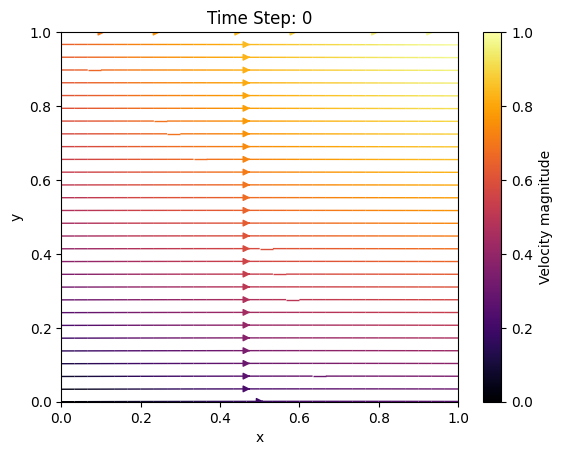

In [22]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

X, Y = np.meshgrid(np.arange(0, 1 + dx, dx), np.arange(0, 1 + dy, dy))

step = 0
strm = ax.streamplot(X, Y, u[:, :, step], v[:, :, step], color=(np.sqrt(u[:, :, step]**2)), linewidth=1, cmap=cm.inferno)
# strm = ax.streamplot(X, Y, u[:, :, step], v[:, :, step], color=(u[:, :, step]), linewidth=1, cmap=cm.inferno)

# obstacle = get_obstacle_mask(ax, u.shape[1], u.shape[0])
# ax.add_patch(obstacle)

ax.set_title("Time Step: {}".format(step))
ax.set_xlim(0, 1)  # Set x-axis limits
ax.set_ylim(0, 1)  # Set y-axis limits
ax.set_xlabel("x")  # Set y-axis limits
ax.set_ylabel("y")  # Set y-axis limits

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cm.inferno, norm=norm)
sm.set_array([])

fig.colorbar(sm, ax=ax, label='Velocity magnitude')

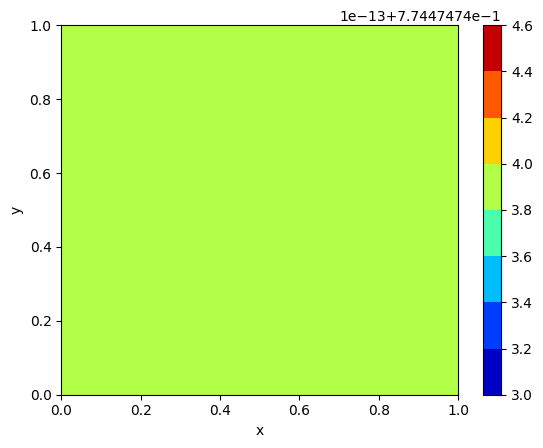

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Create a contour plot of the temperature distribution
step = 99
plt.figure()
plt.contourf(X, Y, np.sqrt(u[:, :, step]**2 + v[:, :, step]**2), cmap="jet")
plt.xlabel("x")
plt.ylabel("y")
plt.title("")
plt.colorbar(label="")
plt.show()

In [16]:
input_dim = 3
output_dim = 3
# hidden_units = [32, 32, 32]
hidden_units = [64, 64, 64, 64]
# hidden_units = [128, 128, 128, 128]

pinn = PINN(input_dim, output_dim, hidden_units).to(device)

# Load the state_dict into the model
pinn.load_state_dict(torch.load("./navier_stokes_pinn_2.pt"))

<All keys matched successfully>

In [17]:
pinn

PINN(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)